In [1]:
import os

In [2]:
# os.environ["OPENBLAS_NUM_THREADS"] = "1"  # For implicit ALS

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np

from implicit.als import AlternatingLeastSquares

from rectools.metrics import Precision, Recall, MAP, calc_metrics
from rectools.models import PopularModel, RandomModel, ImplicitALSWrapperModel
from rectools import Columns
from rectools.dataset import Dataset
from rectools.models import ImplicitALSWrapperModel, LightFMWrapperModel

import matplotlib.pyplot as plt
# import seaborn as sns

import matplotlib.pyplot as plt
from pathlib import Path
import typing as tp
from tqdm import tqdm

from lightfm import LightFM

from implicit.bpr import BayesianPersonalizedRanking

from implicit.lmf import LogisticMatrixFactorization

In [5]:
DATA_PATH = Path("/mnt/88fdd009-dda3-49d8-9888-cfd9d9d5910a/ITMO/RecomendationsService/DATA")

# LOAD DATA 

In [6]:
users = pd.read_csv(DATA_PATH / 'users.csv')
items = pd.read_csv(DATA_PATH / 'items.csv')
interactions = pd.read_csv(DATA_PATH / 'interactions.csv')

In [7]:
interactions

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0


# Preprocess

In [8]:
Columns.Datetime = 'last_watch_dt'

In [9]:
interactions.drop(interactions[interactions[Columns.Datetime].str.len() != 10].index, inplace=True)

In [10]:
interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime], format='%Y-%m-%d')

In [11]:
max_date = interactions[Columns.Datetime].max()

In [12]:
interactions[Columns.Weight] = np.where(interactions['watched_pct'] > 10, 3, 1)

In [13]:
train = interactions[interactions[Columns.Datetime] < max_date - pd.Timedelta(days=7)].copy()
test = interactions[interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=7)].copy()

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (4985269, 6)
test: (490982, 6)


In [14]:
train.drop(train.query("total_dur < 300").index, inplace=True)

In [15]:
# отфильтруем холодных пользователей из теста
cold_users = set(test[Columns.User]) - set(train[Columns.User])

In [16]:
test.drop(test[test[Columns.User].isin(cold_users)].index, inplace=True)

# Prepare features

## User features

In [17]:
users.isnull().sum()

user_id         0
age         14095
income      14776
sex         13831
kids_flg        0
dtype: int64

In [18]:
users.fillna('Unknown', inplace=True)

In [19]:
users.nunique()

user_id     840197
age              7
income           7
sex              3
kids_flg         2
dtype: int64

In [20]:
users = users.loc[users[Columns.User].isin(train[Columns.User])].copy()

In [21]:
users

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0
5,1037719,age_45_54,income_60_90,М,0
...,...,...,...,...,...
840184,529394,age_25_34,income_40_60,Ж,0
840186,80113,age_25_34,income_40_60,Ж,0
840188,312839,age_65_inf,income_60_90,Ж,0
840189,191349,age_45_54,income_40_60,М,1


In [22]:
user_features_frames = []
for feature in ["sex", "age", "income"]:
    feature_frame = users.reindex(columns=[Columns.User, feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    user_features_frames.append(feature_frame)
user_features = pd.concat(user_features_frames)
user_features.head()

,id,value,feature
0,973171,М,sex
1,962099,М,sex
3,721985,Ж,sex
4,704055,Ж,sex
5,1037719,М,sex


In [23]:
user_features.query(f"id == 973171")

,id,value,feature
0,973171,М,sex
0,973171,age_25_34,age
0,973171,income_60_90,income


# Item features

In [24]:
items.isnull().sum()

item_id             0
content_type        0
title               0
title_orig       4745
release_year       98
genres              0
countries          37
for_kids        15397
age_rating          2
studios         14898
directors        1509
actors           2619
description         2
keywords          423
dtype: int64

In [25]:
items = items.loc[items[Columns.Item].isin(train[Columns.Item])].copy()

In [26]:
items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [27]:
items.nunique()

item_id         14019
content_type        2
title           13454
title_orig       9724
release_year      104
genres           2559
countries         666
for_kids            2
age_rating          6
studios            38
directors        7414
actors          11830
description     13791
keywords        13583
dtype: int64

### Genre

In [28]:
# Explode genres to flatten table
items["genre"] = items["genres"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"
genre_feature.head()

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


In [29]:
genre_feature["value"].value_counts()

драмы                 4923
комедии               3479
зарубежные            3055
мелодрамы             2533
триллеры              2297
                      ... 
токшоу                   2
красота и здоровье       2
передачи                 1
образование              1
рекомендуем              1
Name: value, Length: 94, dtype: int64

### Content

In [30]:
content_feature = items.reindex(columns=[Columns.Item, "content_type"])
content_feature.columns = ["id", "value"]
content_feature["feature"] = "content_type"

In [31]:
content_feature

,id,value,feature
0,10711,film,content_type
1,2508,film,content_type
2,10716,film,content_type
3,7868,film,content_type
4,16268,film,content_type
...,...,...,...
15958,6443,series,content_type
15959,2367,series,content_type
15960,10632,series,content_type
15961,4538,series,content_type


In [32]:
content_feature['value'].value_counts()

film      10662
series     3357
Name: value, dtype: int64

In [33]:
item_features = pd.concat((genre_feature, content_feature))

In [34]:
item_features

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre
...,...,...,...
15958,6443,series,content_type
15959,2367,series,content_type
15960,10632,series,content_type
15961,4538,series,content_type


# Metrics

In [35]:
metrics_name = {
    'Precision': Precision,
    'Recall': Recall,
    'MAP': MAP,
}

metrics = {}
for metric_name, metric in metrics_name.items():
    for k in range(1, 11):
        metrics[f'{metric_name}@{k}'] = metric(k=k)

In [36]:
metrics

{'Precision@1': Precision(k=1),
 'Precision@2': Precision(k=2),
 'Precision@3': Precision(k=3),
 'Precision@4': Precision(k=4),
 'Precision@5': Precision(k=5),
 'Precision@6': Precision(k=6),
 'Precision@7': Precision(k=7),
 'Precision@8': Precision(k=8),
 'Precision@9': Precision(k=9),
 'Precision@10': Precision(k=10),
 'Recall@1': Recall(k=1),
 'Recall@2': Recall(k=2),
 'Recall@3': Recall(k=3),
 'Recall@4': Recall(k=4),
 'Recall@5': Recall(k=5),
 'Recall@6': Recall(k=6),
 'Recall@7': Recall(k=7),
 'Recall@8': Recall(k=8),
 'Recall@9': Recall(k=9),
 'Recall@10': Recall(k=10),
 'MAP@1': MAP(k=1, divide_by_k=False),
 'MAP@2': MAP(k=2, divide_by_k=False),
 'MAP@3': MAP(k=3, divide_by_k=False),
 'MAP@4': MAP(k=4, divide_by_k=False),
 'MAP@5': MAP(k=5, divide_by_k=False),
 'MAP@6': MAP(k=6, divide_by_k=False),
 'MAP@7': MAP(k=7, divide_by_k=False),
 'MAP@8': MAP(k=8, divide_by_k=False),
 'MAP@9': MAP(k=9, divide_by_k=False),
 'MAP@10': MAP(k=10, divide_by_k=False)}

# Models

In [37]:
K_RECOS = 10
RANDOM_STATE = 42
NUM_THREADS = 8
N_FACTORS = (32,)
N_EPOCHS = 1 # Lightfm
USER_ALPHA = 0 # Lightfm
ITEM_ALPHA = 0 # Lightfm
LEARNING_RATE = 0.05 # Lightfm

In [38]:
models = {
    'popular': PopularModel(),
}

In [39]:
implicit_models = {
    'ALS': AlternatingLeastSquares,
}
for implicit_name, implicit_model in implicit_models.items():
    for is_fitting_features in (True, False):
        for n_factors in N_FACTORS:
            models[f"{implicit_name}_{n_factors}_{is_fitting_features}"] = (
                ImplicitALSWrapperModel(
                    model=implicit_model(
                        factors=n_factors, 
                        random_state=RANDOM_STATE, 
                        num_threads=NUM_THREADS,
                    ),
                    fit_features_together=is_fitting_features,
                )
            )

In [40]:
lightfm_losses = ('logistic', 'bpr', 'warp')

for loss in lightfm_losses:
    for n_factors in N_FACTORS:
        models[f"LightFM_{loss}_{n_factors}"] = LightFMWrapperModel(
            LightFM(
                no_components=n_factors, 
                loss=loss, 
                random_state=RANDOM_STATE,
                learning_rate=LEARNING_RATE,
                user_alpha=USER_ALPHA,
                item_alpha=ITEM_ALPHA,
            ),
            epochs=N_EPOCHS,
            num_threads=NUM_THREADS,
        )

In [41]:
models

{'popular': <rectools.models.popular.PopularModel at 0x7ff964dfb7f0>,
 'ALS_32_True': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7ff96842a530>,
 'ALS_32_False': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7ff964df94b0>,
 'LightFM_logistic_32': <rectools.models.lightfm.LightFMWrapperModel at 0x7ff964dfa860>,
 'LightFM_bpr_32': <rectools.models.lightfm.LightFMWrapperModel at 0x7ff964dfbd60>,
 'LightFM_warp_32': <rectools.models.lightfm.LightFMWrapperModel at 0x7ff964dfaaa0>}

In [42]:
# %%time
dataset = Dataset.construct(
    interactions_df=train,
    user_features_df=user_features,
    cat_user_features=["sex", "age", "income"],
    item_features_df=item_features,
    cat_item_features=["genre", "content_type"],
)

In [98]:
user_features
dataset.user_id_map.convert_to_external

,id,value,feature
0,973171,М,sex
1,962099,М,sex
3,721985,Ж,sex
4,704055,Ж,sex
5,1037719,М,sex
...,...,...,...
840184,529394,income_40_60,income
840186,80113,income_40_60,income
840188,312839,income_60_90,income
840189,191349,income_40_60,income


In [99]:
dataset.user_id_map.convert_to_external

IdMap(external_ids=array([ 176549,  699317,  864613, ...,   92876, 1007900,  882138]))

In [101]:
len(train[Columns.User].unique())

756562

In [44]:
TEST_USERS = test[Columns.User].unique()

In [45]:
%%time
results = []
for model_name, model in models.items():
    print(f"Fitting model {model_name}...")
    model_quality = {'model': model_name}

    model.fit(dataset)
    recos = model.recommend(
        users=TEST_USERS,
        dataset=dataset,
        k=K_RECOS,
        filter_viewed=True,
    )
    metric_values = calc_metrics(metrics, recos, test, train)
    model_quality.update(metric_values)
    results.append(model_quality)

Fitting model popular...
Fitting model ALS_32_True...
Fitting model ALS_32_False...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting model LightFM_logistic_32...
Fitting model LightFM_bpr_32...
Fitting model LightFM_warp_32...
CPU times: user 39min 49s, sys: 58min 20s, total: 1h 38min 10s
Wall time: 7min 9s


In [46]:
df_quality = pd.DataFrame(results).T

df_quality.columns = df_quality.iloc[0]

df_quality.drop('model', inplace=True)

In [47]:
df_quality.style.highlight_max(color='lightgreen', axis=1)

model,popular,ALS_32_True,ALS_32_False,LightFM_logistic_32,LightFM_bpr_32,LightFM_warp_32
Precision@1,0.069368,0.081539,0.060950,0.000363,0.035512,0.080946
Recall@1,0.035863,0.042035,0.030516,0.000116,0.019990,0.041207
Precision@2,0.063681,0.069200,0.054060,0.000469,0.025673,0.068434
Recall@2,0.064597,0.069700,0.052987,0.000301,0.028270,0.067291
Precision@3,0.059233,0.059564,0.049863,0.000313,0.020662,0.060555
Recall@3,0.088080,0.088042,0.072278,0.000301,0.033614,0.088113
Precision@4,0.057348,0.052674,0.046266,0.000237,0.017174,0.054551
Recall@4,0.112881,0.102603,0.088341,0.000302,0.036885,0.105148
Precision@5,0.051035,0.047010,0.042770,0.000200,0.014842,0.049683
Recall@5,0.124184,0.113129,0.100520,0.000314,0.039362,0.118886


# Approximate Nearest Neighbors 

In [48]:
import nmslib

# HNSW algorithm parameters

## Search parameters:
* ```ef``` - the size of the dynamic list for the nearest neighbors (used during the search). Higher ```ef```
leads to more accurate but slower search. ```ef``` cannot be set lower than the number of queried nearest neighbors
```k```. The value ```ef``` of can be anything between ```k``` and the size of the dataset.
* ```k``` number of nearest neighbors to be returned as the result.
The ```knn_query``` function returns two numpy arrays, containing labels and distances to the k found nearest 
elements for the queries. Note that in case the algorithm is not be able to find ```k``` neighbors to all of the queries,
(this can be due to problems with graph or ```k```>size of the dataset) an exception is thrown.


## Construction parameters:
* ```M``` - the number of bi-directional links created for every new element during construction. Reasonable range for ```M``` 
is 2-100. Higher ```M``` work better on datasets with high intrinsic dimensionality and/or high recall, while low ```M``` work 
better for datasets with low intrinsic dimensionality and/or low recalls. The parameter also determines the algorithm's memory 
consumption, which is roughly ```M * 8-10``` bytes per stored element.  
As an example for ```dim```=4 random vectors optimal ```M``` for search is somewhere around 6, while for high dimensional datasets 
(word embeddings, good face descriptors), higher ```M``` are required (e.g. ```M```=48-64) for optimal performance at high recall. 
The range ```M```=12-48 is ok for the most of the use cases. When ```M``` is changed one has to update the other parameters. 
Nonetheless, ef and ef_construction parameters can be roughly estimated by assuming that ```M```*```ef_{construction}``` is 
a constant.

* ```ef_construction``` - the parameter has the same meaning as ```ef```, but controls the index_time/index_accuracy. Bigger 
ef_construction leads to longer construction, but better index quality. At some point, increasing ef_construction does
not improve the quality of the index. One way to check if the selection of ef_construction was ok is to measure a recall 
for M nearest neighbor search when ```ef``` =```ef_construction```: if the recall is lower than 0.9, than there is room 
for improvement.
* ```num_elements``` - defines the maximum number of elements in the index. The index can be extened by saving/loading(load_index
function has a parameter which defines the new maximum number of elements).

Еще источники: 
- [Nmslib Docs](https://github.com/nmslib/nmslib/blob/master/manual/methods.md)
- [Pinecone Vector Indexes](https://www.pinecone.io/learn/vector-indexes/)

<img src="https://d33wubrfki0l68.cloudfront.net/4c635fabb268a4af60109a506300a2dfda612063/d2535/images/similarity-search-indexes17.jpg">

<img src="https://d33wubrfki0l68.cloudfront.net/96d80cd46c2d12df99c044c860a8a5fb00cf6376/d59ca/images/similarity-search-indexes18.jpg">

In [49]:
import time

In [90]:
model

In [51]:
user_embeddings, item_embeddings = model.get_vectors(dataset)

In [52]:
user_embeddings.shape, item_embeddings.shape

((756562, 34), (14019, 34))

----

In [103]:
models['ALS_32_True']

In [105]:
user_embeddings_1, item_embeddings_1 = models['ALS_32_True'].get_vectors()

In [106]:
user_embeddings_1.shape, item_embeddings_1.shape

((756562, 145), (14019, 145))

----

In [53]:
def augment_inner_product(factors):
    normed_factors = np.linalg.norm(factors, axis=1)
    max_norm = normed_factors.max()
    
    extra_dim = np.sqrt(max_norm ** 2 - normed_factors ** 2).reshape(-1, 1)
    augmented_factors = np.append(factors, extra_dim, axis=1)
    return max_norm, augmented_factors

In [54]:
print('pre shape: ', item_embeddings.shape)
max_norm, augmented_item_embeddings = augment_inner_product(item_embeddings)
augmented_item_embeddings.shape

pre shape:  (14019, 34)


(14019, 35)

In [55]:
extra_zero = np.zeros((user_embeddings.shape[0], 1))
augmented_user_embeddings = np.append(user_embeddings, extra_zero, axis=1)
augmented_user_embeddings.shape

(756562, 35)

In [56]:
user_id = 30

In [57]:
user_embeddings[user_id]

array([-2.25456482e+02,  1.00000000e+00,  7.01399744e-02, -2.47256398e-01,
        2.79070556e-01,  2.70212628e-02, -2.50095636e-01, -4.38749902e-02,
        5.08583337e-03, -1.43794343e-04,  2.61061549e-01, -1.40316561e-01,
        4.07728314e-01,  1.68389738e-01,  2.00082302e-01,  2.26111695e-01,
       -2.01466441e-01,  1.94868207e-01,  3.69164795e-01, -1.19172722e-01,
       -2.39566818e-01,  2.38857687e-01, -1.30120248e-01,  3.15435350e-01,
       -4.02139485e-01, -1.92906931e-02,  2.98904359e-01, -3.48710239e-01,
        2.26153322e-02, -2.67659992e-01, -3.34021747e-01,  2.10244745e-01,
        2.73165613e-01,  1.41473964e-01])

In [58]:
augmented_user_embeddings[user_id]

array([-2.25456482e+02,  1.00000000e+00,  7.01399744e-02, -2.47256398e-01,
        2.79070556e-01,  2.70212628e-02, -2.50095636e-01, -4.38749902e-02,
        5.08583337e-03, -1.43794343e-04,  2.61061549e-01, -1.40316561e-01,
        4.07728314e-01,  1.68389738e-01,  2.00082302e-01,  2.26111695e-01,
       -2.01466441e-01,  1.94868207e-01,  3.69164795e-01, -1.19172722e-01,
       -2.39566818e-01,  2.38857687e-01, -1.30120248e-01,  3.15435350e-01,
       -4.02139485e-01, -1.92906931e-02,  2.98904359e-01, -3.48710239e-01,
        2.26153322e-02, -2.67659992e-01, -3.34021747e-01,  2.10244745e-01,
        2.73165613e-01,  1.41473964e-01,  0.00000000e+00])

In [59]:
item_id = 0

In [60]:
item_embeddings[item_id]

array([ 1.        ,  1.65007734, -0.20667538, -1.04957533,  0.84888887,
       -0.04721972, -0.27385291, -0.40841329,  1.01407611, -0.10429232,
       -0.01295139, -0.26090294, -0.23002586,  1.0479362 ,  0.93981457,
        0.09367985, -0.4818188 ,  0.9489696 ,  0.72209001, -1.02999854,
        0.06911039,  0.88899964, -0.44631544,  0.2837396 , -0.6621598 ,
        0.45825192,  1.01752782, -1.43694818,  0.68702167, -0.61883521,
       -1.35327554,  0.3081077 ,  0.24885717,  0.97186196])

In [61]:
augmented_item_embeddings[item_id]

array([ 1.        ,  1.65007734, -0.20667538, -1.04957533,  0.84888887,
       -0.04721972, -0.27385291, -0.40841329,  1.01407611, -0.10429232,
       -0.01295139, -0.26090294, -0.23002586,  1.0479362 ,  0.93981457,
        0.09367985, -0.4818188 ,  0.9489696 ,  0.72209001, -1.02999854,
        0.06911039,  0.88899964, -0.44631544,  0.2837396 , -0.6621598 ,
        0.45825192,  1.01752782, -1.43694818,  0.68702167, -0.61883521,
       -1.35327554,  0.3081077 ,  0.24885717,  0.97186196,  3.77649645])

In [62]:
# Set index parameters
# These are the most important ones
M = 48
efC = 100

num_threads = 8
index_time_params = {'M': M, 'indexThreadQty': num_threads, 'efConstruction': efC, 'post' : 0}
print('Index-time parameters', index_time_params)

Index-time parameters {'M': 48, 'indexThreadQty': 8, 'efConstruction': 100, 'post': 0}


In [63]:
# Number of neighbors 
K=10

In [64]:
# Space name should correspond to the space name 
# used for brute-force search
space_name='negdotprod'

In [65]:
# Intitialize the library, specify the space, the type of the vector and add data points 
index = nmslib.init(method='hnsw', space=space_name, data_type=nmslib.DataType.DENSE_VECTOR) 
index.addDataPointBatch(augmented_item_embeddings) 

14019

In [67]:
# Create an index
start = time.time()
index_time_params = {'M': M, 'indexThreadQty': num_threads, 'efConstruction': efC}
index.createIndex(index_time_params) 
end = time.time() 
print('Index-time parameters', index_time_params)
print('Indexing time = %f' % (end-start))

Index-time parameters {'M': 48, 'indexThreadQty': 8, 'efConstruction': 100}
Indexing time = 0.160192


In [68]:
# Setting query-time parameters
efS = 100
query_time_params = {'efSearch': efS}
print('Setting query-time parameters', query_time_params)
index.setQueryTimeParams(query_time_params)

Setting query-time parameters {'efSearch': 100}


In [69]:
query_matrix = augmented_user_embeddings[:1000, :]

In [70]:
# Querying
query_qty = query_matrix.shape[0]
start = time.time() 
nbrs = index.knnQueryBatch(query_matrix, k = K, num_threads = num_threads)
end = time.time() 
print('kNN time total=%f (sec), per query=%f (sec), per query adjusted for thread number=%f (sec)' % 
      (end-start, float(end-start)/query_qty, num_threads*float(end-start)/query_qty)) 

kNN time total=0.008845 (sec), per query=0.000009 (sec), per query adjusted for thread number=0.000071 (sec)


In [71]:
nbrs[0]

(array([ 43,  32,  62,  19,   8,  36, 347,  69, 528, 305], dtype=int32),
 array([194.95813, 195.12988, 195.55359, 195.59747, 195.66373, 195.72945,
        195.7943 , 195.89827, 195.96326, 195.97185], dtype=float32))

In [72]:
nbrs[0][1]

array([194.95813, 195.12988, 195.55359, 195.59747, 195.66373, 195.72945,
       195.7943 , 195.89827, 195.96326, 195.97185], dtype=float32)

In [73]:
def recommend_all(query_factors, index_factors, topn=10):
    output = query_factors.dot(index_factors.T)
    argpartition_indices = np.argpartition(output, -topn)[:, -topn:]

    x_indices = np.repeat(np.arange(output.shape[0]), topn)
    y_indices = argpartition_indices.flatten()
    top_value = output[x_indices, y_indices].reshape(output.shape[0], topn)
    top_indices = np.argsort(top_value)[:, ::-1]

    y_indices = top_indices.flatten()
    top_indices = argpartition_indices[x_indices, y_indices]
    labels = top_indices.reshape(-1, topn)
    distances = output[x_indices, top_indices].reshape(-1, topn)
    return labels, distances

In [74]:
recommend_all(user_embeddings[[0], :], item_embeddings)

(array([[ 43,  32,  62,  19,   8,  36, 347,  69, 528, 305]]),
 array([[-194.95812062, -195.12985243, -195.5535836 , -195.59745774,
         -195.66375784, -195.72943998, -195.79428444, -195.89827764,
         -195.96325074, -195.97184353]]))

In [75]:
item_embeddings[:1000, :].shape, user_embeddings.shape

((1000, 34), (756562, 34))

In [76]:
query_matrix_not_augmented = user_embeddings[:1000, :]

In [77]:
%%timeit
recommend_all(query_matrix_not_augmented, item_embeddings)

146 ms ± 740 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [78]:
%%timeit
index.knnQueryBatch(query_matrix, k = K, num_threads=num_threads)

6.39 ms ± 796 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [80]:
import hnswlib

# %%time
max_elements, dim = augmented_item_embeddings.shape
hnsw = hnswlib.Index("ip", dim) # possible options for space are l2, cosine or ip

# Initing index - the maximum number of elements should be known beforehand
hnsw.init_index(max_elements, M, efC)

# Element insertion (can be called several times)
hnsw.add_items(augmented_item_embeddings)

# Controlling the recall by setting ef, should always be > k
hnsw.set_ef(efS)

label, distance = hnsw.knn_query(query_matrix, k=k)

In [81]:
# Controlling the recall by setting ef, should always be > k
hnsw.set_ef(efS)

In [82]:
label, distance = hnsw.knn_query(query_matrix, k=k)

In [83]:
label

array([[ 43,  32,  62, ...,  69, 528, 305],
       [ 62,   8,  43, ..., 262,  49,  19],
       [ 31,  19, 121, ...,  32,  12, 100],
       ...,
       [ 31,  19, 358, ..., 166, 173, 121],
       [ 43,  19,  32, ..., 117,  62,  75],
       [ 31,  32,  19, ...,   8, 173,  36]], dtype=uint64)

In [84]:
1 - distance

array([[-194.95813  , -195.12988  , -195.55357  , ..., -195.89827  ,
        -195.96324  , -195.97186  ],
       [-195.5226   , -195.65256  , -195.96494  , ..., -196.24266  ,
        -196.28024  , -196.32687  ],
       [-181.90443  , -182.46126  , -182.9825   , ..., -183.28624  ,
        -183.31169  , -183.32512  ],
       ...,
       [-218.01886  , -218.17645  , -218.25363  , ..., -218.60023  ,
        -218.64053  , -218.67365  ],
       [-198.77481  , -199.01605  , -199.17645  , ..., -199.52682  ,
        -199.57887  , -199.66626  ],
       [   6.0184584,    5.8763576,    5.6622257, ...,    5.3207345,
           5.277447 ,    5.2311406]], dtype=float32)

In [85]:
item_embeddings[8867].dot(user_embeddings[0])

-203.00963453184738

In [86]:
labels, distances = recommend_all(user_embeddings[:1000, :], item_embeddings)
print(labels)
print(distances)

[[ 43  32  62 ...  69 528 305]
 [ 62   8  43 ... 262  49  19]
 [ 31  19 121 ...  32  12 100]
 ...
 [ 31  19 358 ... 166 173 121]
 [ 43  19  32 ... 117  62  75]
 [ 31  32  19 ...   8 173  36]]
[[-194.95812062 -195.12985243 -195.5535836  ... -195.89827764
  -195.96325074 -195.97184353]
 [-195.52257311 -195.65258332 -195.964932   ... -196.24267365
  -196.28023016 -196.32684488]
 [-181.90444136 -182.46127289 -182.98249042 ... -183.28621011
  -183.31169729 -183.32510954]
 ...
 [-218.01888762 -218.17647516 -218.25363732 ... -218.60023105
  -218.64053126 -218.67366424]
 [-198.77479336 -199.01605265 -199.17644531 ... -199.52682488
  -199.57887019 -199.66625941]
 [   6.01845792    5.87635788    5.66222589 ...    5.32073475
     5.27744772    5.2311401 ]]


## Домашнее задание 
### Основные пункты оценки
1. значение метрики на лидерборде
2. ревью кода в ноутбуке 
3. реализация сервиса для модели

Вы можете сделать НЕ ВСЕ пункты и все равно получить 20 баллов. Получение > 20 баллов будет расцениваться как 20.

### Подробности
#### 1. Побейте метрику на лидерборде map@10 = 0.075 c моделью из implicit, lightfm или rectools, в том числе используя ANN **(5 баллов)**
#### 2. Реализуйте эксперименты с кастомной моделю kNN с семинара. Результат - ноутбук(и) **(максимум 12 баллов)**
Что можно сделать в ноутбуке:
- Реализовать тюнинг гиперпараметров для моделей из implicit, lightfm или rectools **(3 балла)**
  - Для перебора гиперпараметров можно использовать [`Optuna`](https://github.com/optuna/optuna), [`Hyperopt`](https://github.com/hyperopt/hyperopt)
- Воспользоваться методом приближенного поиска соседей для выдачи рекомендаций. **(3 балла)**
    - Можно использовать любые удобные: [`Annoy`](https://github.com/spotify/annoy), [`nmslib`](https://github.com/nmslib/nmslib) и.т.д
- Сделать рекомендации для холодных пользователей используя их фичи (для кого нет фичей - там другим способом) **(3 балла)**
- Провести эксперименты с параметрами оффлайн валидации и сделать выводы **(3 балла)**

#### 3. Оберните модель в сервис **(максимум 12 баллов)**
- предпочтительный онлайн вариант: обучаете модель в ноутбуке, сохраняете обученную модель (pickle, dill), при запуске сервиса ее поднимаете и запрашиваете рекомендации "на лету" **(12 баллов)**
- или оффлайн вариант: предварительно посчитайте рекомендации для всех пользователей, сохраните и запрашивайте их **(6 баллов)**

### Хороший pull request - это:
- наличие описания (в идеале что сделано - по пунктам)
- код по стандарту PEP8
- легкая читаемость и воспроизводимость кода
- комментарии и объяснения. В ipynb пользуйтесь силой маркдауна. В скриптах пишите комментарии и докстринг.
- обоснование схемы валидации
- анализ метрики качества

In [87]:
import annoy
import nmslib

#### Картинка зависимости точности от скорости работы разных алгоритмов
Логичнее всего использовать nmslib
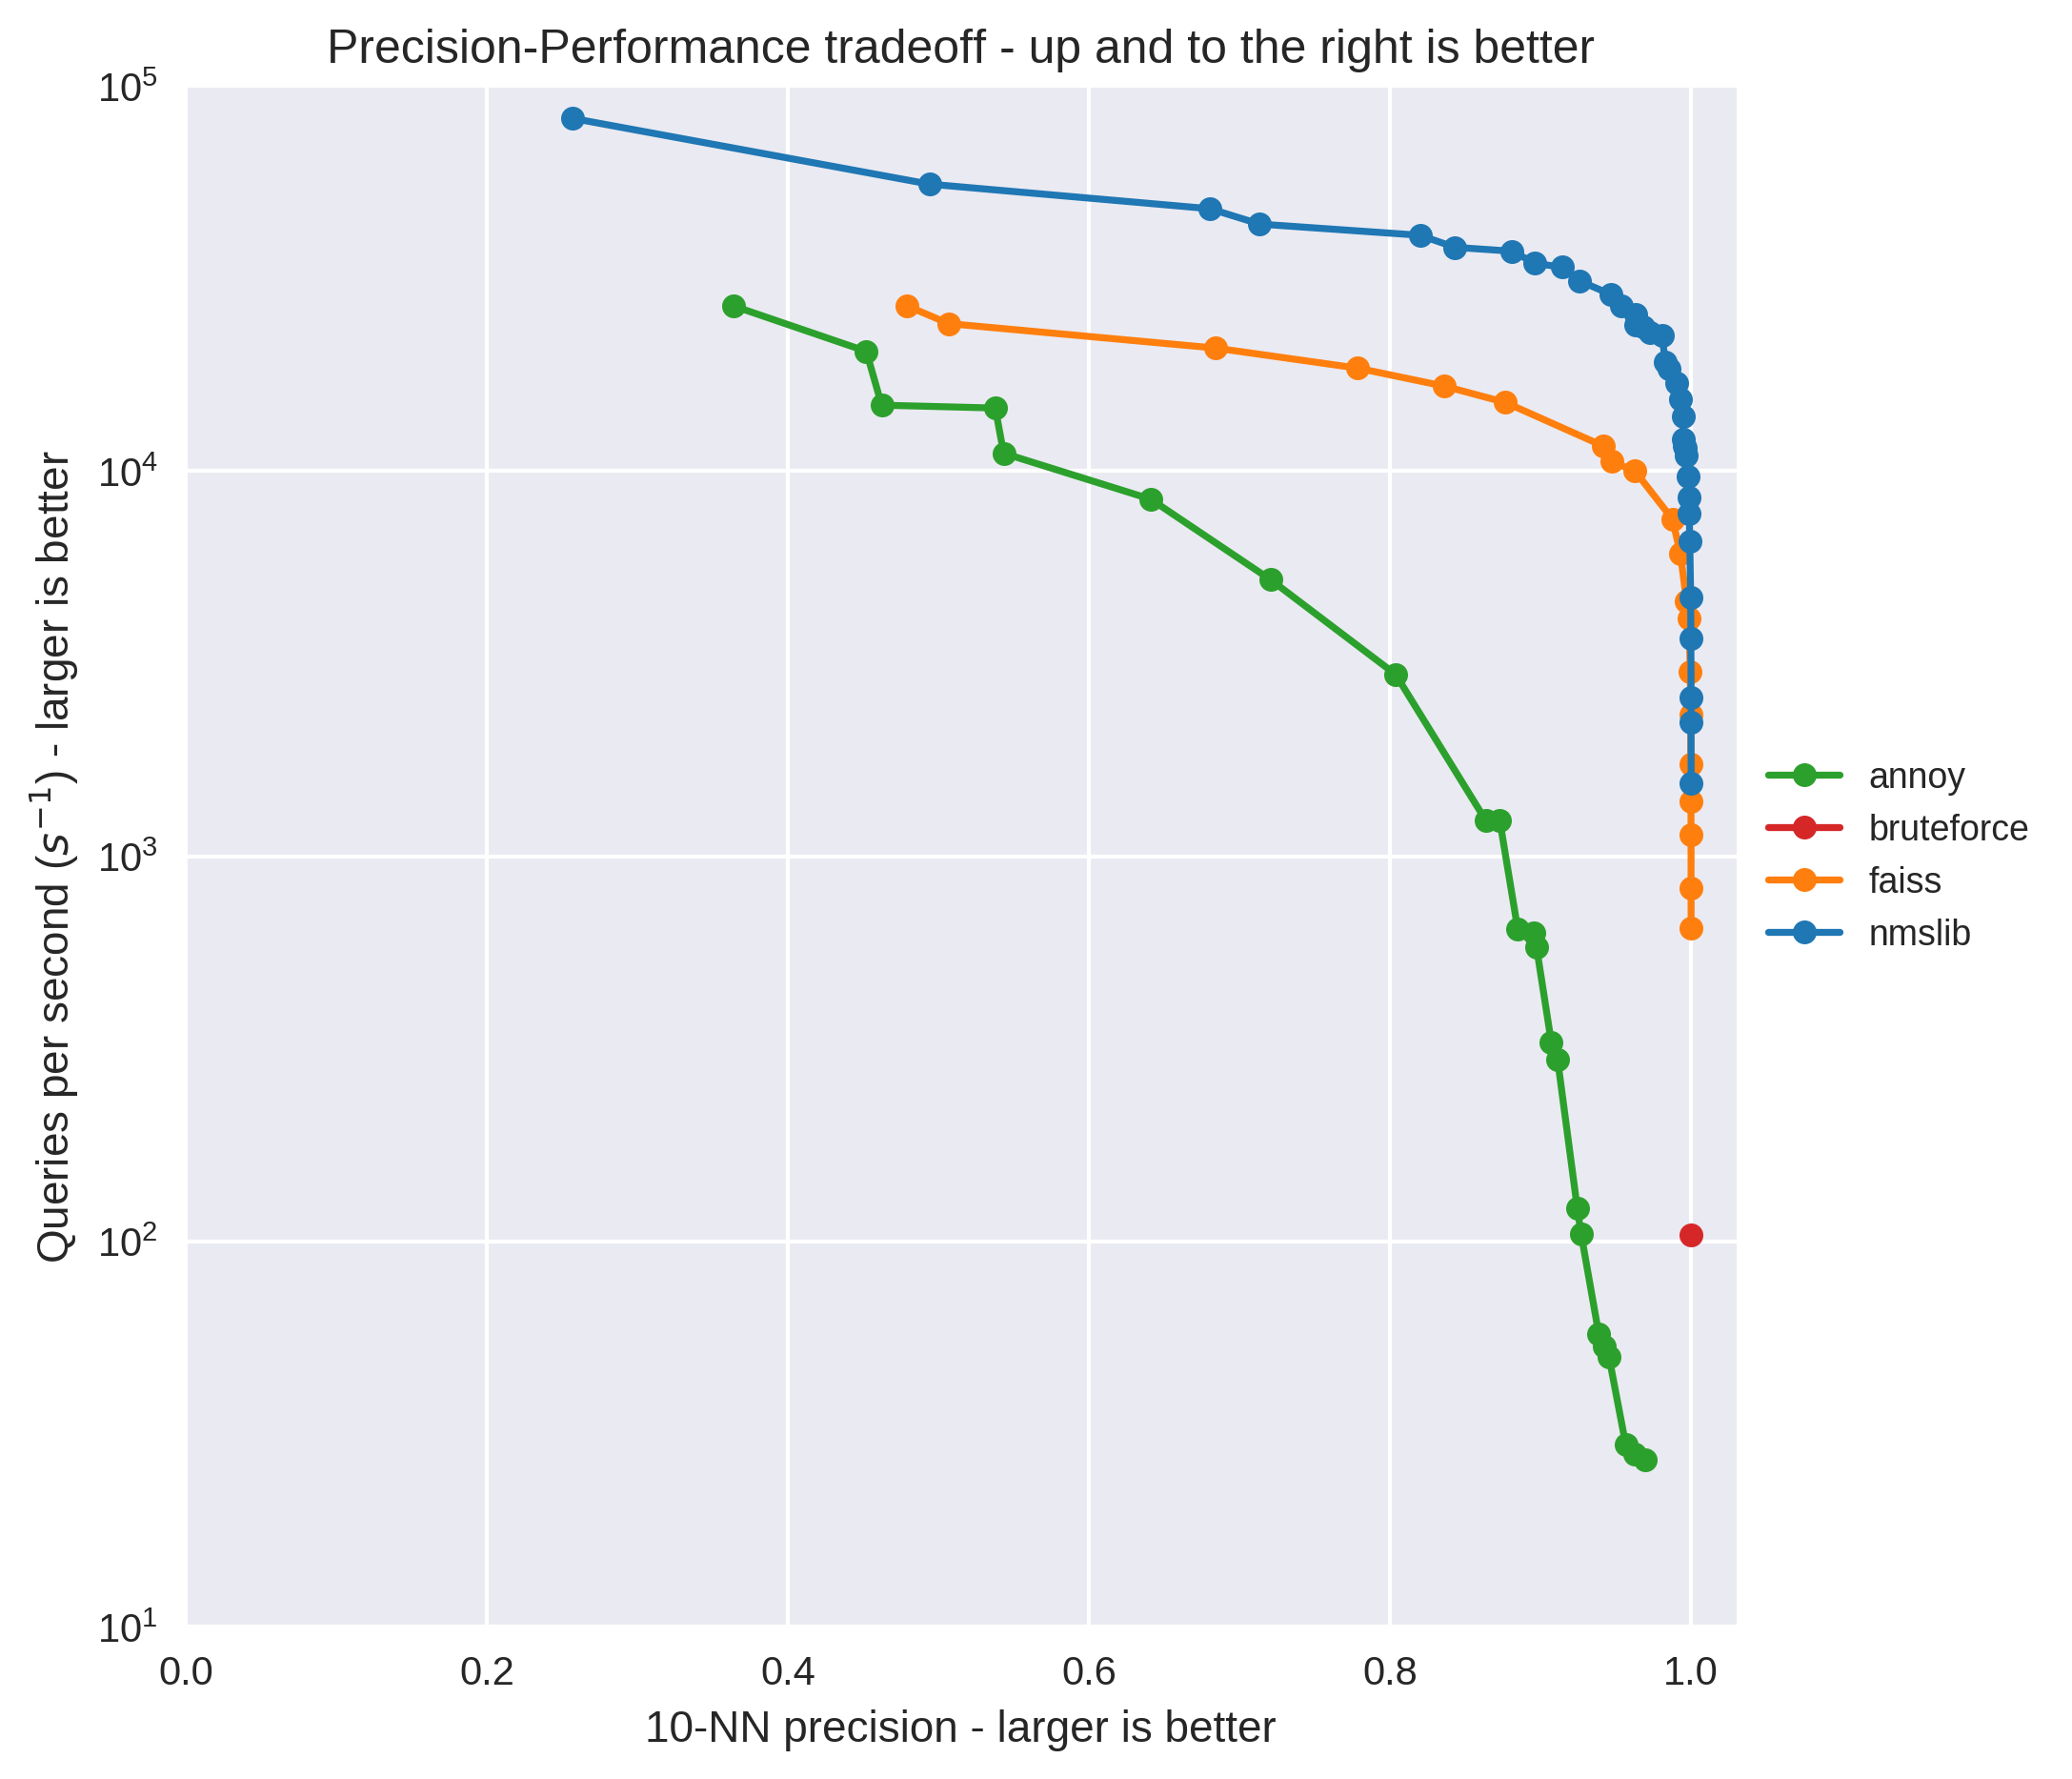

In [88]:
import nmslib
import numpy

# create a random matrix to index
data = numpy.random.randn(10000, 100).astype(numpy.float32)

# initialize a new index, using a HNSW index on Cosine Similarity
index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(data)
index.createIndex({'post': 2}, print_progress=True)

# query for the nearest neighbours of the first datapoint
ids, distances = index.knnQuery(data[0], k=10)

# get all nearest neighbours for all the datapoint
# using a pool of 4 threads to compute
neighbours = index.knnQueryBatch(data, k=10, num_threads=8)


0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

In [89]:
%%time

neighbours = index.knnQueryBatch(data, k=10, num_threads=8)

CPU times: user 510 ms, sys: 0 ns, total: 510 ms
Wall time: 77.5 ms


In [ ]:
class AnnRecommender():
    def __init__(self, user_features, item_features, embedder: ImplicitALSWrapperModel | LightFMWrapperModel, n_recos: int = 10):
        # self.user_features = user_features
        # self.item_features = item_features
        self.embedder = embedder
        self.n_recos = n_recos
        
        self.user_id_map
        
    def fit(self, dataset: Dataset):
        self.embedder.fit(dataset)
        
        self.user_id_map = dataset.user_id_map
        self.item_id_map = dataset.item_id_map
        
        if type(self.embedder) == ImplicitALSWrapperModel:
            self.user_embeddings, self.item_embeddings = models['ALS_32_True'].get_vectors()
        else:
            self.user_embeddings, self.item_embeddings = models['ALS_32_True'].get_vectors(dataset)
        
        
        pass
    
    def recommend(self, ids, n_recos):
        if k_recos is None:
            k_recos = self.n_recos
    
    def recommend_single(self, id, n_recos=None):
        if k_recos is None:
            k_recos = self.n_recos
        
        pass

In [107]:
models

{'popular': <rectools.models.popular.PopularModel at 0x7ff964dfb7f0>,
 'ALS_32_True': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7ff96842a530>,
 'ALS_32_False': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x7ff964df94b0>,
 'LightFM_logistic_32': <rectools.models.lightfm.LightFMWrapperModel at 0x7ff964dfa860>,
 'LightFM_bpr_32': <rectools.models.lightfm.LightFMWrapperModel at 0x7ff964dfbd60>,
 'LightFM_warp_32': <rectools.models.lightfm.LightFMWrapperModel at 0x7ff964dfaaa0>}

In [ ]:
implicit_models = {
    'ALS': AlternatingLeastSquares,
}
for implicit_name, implicit_model in implicit_models.items():
    for is_fitting_features in (True, False):
        for n_factors in N_FACTORS:
            models[f"{implicit_name}_{n_factors}_{is_fitting_features}"] = (
                ImplicitALSWrapperModel(
                    model=implicit_model(
                        factors=n_factors, 
                        random_state=RANDOM_STATE, 
                        num_threads=NUM_THREADS,
                    ),
                    fit_features_together=is_fitting_features,
                )
            )


lightfm_losses = ('logistic', 'bpr', 'warp')

for loss in lightfm_losses:
    for n_factors in N_FACTORS:
        models[f"LightFM_{loss}_{n_factors}"] = LightFMWrapperModel(
            LightFM(
                no_components=n_factors, 
                loss=loss, 
                random_state=RANDOM_STATE,
                learning_rate=LEARNING_RATE,
                user_alpha=USER_ALPHA,
                item_alpha=ITEM_ALPHA,
            ),
            epochs=N_EPOCHS,
            num_threads=NUM_THREADS,
        )


%%time
results = []
for model_name, model in models.items():
    print(f"Fitting model {model_name}...")
    model_quality = {'model': model_name}

    model.fit(dataset)
    recos = model.recommend(
        users=TEST_USERS,
        dataset=dataset,
        k=K_RECOS,
        filter_viewed=True,
    )
    metric_values = calc_metrics(metrics, recos, test, train)
    model_quality.update(metric_values)
    results.append(model_quality)

In [ ]:
user_features
dataset.user_id_map.convert_to_external

----

In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_float('x', -10, 10)
    return (x - 2) ** 2

study = optuna.create_study()
study.optimize(objective, n_trials=100)

study.best_params  # E.g. {'x': 2.002108042}

In [167]:
from typing import Literal 

def transform_embeddings(embeddings, embedd_type: Literal['items', 'users']):
    if embedd_type == 'items':
        normed_embeddings = np.linalg.norm(embeddings, axis=1)
        max_norm = normed_embeddings.max()
        extra_dim = np.sqrt(max_norm ** 2 - normed_embeddings ** 2).reshape(-1, 1)
    else:
        extra_dim = np.zeros((user_embeddings.shape[0], 1))

    augmented_factors = np.append(embeddings, extra_dim, axis=1)
    return augmented_factors


class HNSWrapper():
    def __init__(self, dim_size, n_neighbours=10, **params_dict) -> None:
        # space_type: Literal['l2', 'cosine', 'ip']='l2'
        # M:int=48,
        self.M = params_dict['M']
        self.efc = params_dict['efConstruction']
        space_type = params_dict['space_type']
        self.n_neighbours = n_neighbours
        self.hnsw = hnswlib.Index(space_type, dim_size)
        
        
    def fit(self, vectors):
        self.hnsw.init_index(len(vectors), self.M, self.efc)
        self.hnsw.add_items(vectors)
        self.hnsw.set_ef(efS)
    
    def predict(self, vector): 
        label, distance = self.hnsw.knn_query(vector, k=self.n_neighbours, num_threads=8)
        return list(label[0])

class AnnoyWrapper():
    def __init__(self, dim_size, n_neighbours=10, **params_dict) -> None:
        # metric='angular', n_trees=10
        metric = params_dict['metric']
        self.n_trees = params_dict['n_trees']
        
        self.index = AnnoyIndex(dim_size, metric)
        self.n_neighbours = n_neighbours
    
    def fit(self, vectors):
        for i in range(len(vectors)):
            self.index.add_item(i, vectors[i])
        self.index.build(self.n_trees)
    
    def predict(self, vector):
        return(self.index.get_nns_by_vector(vector, self.n_neighbours))

class NMSLIBWrapper():
    def __init__(self, dim_size, n_neighbours=10, **params_dict) -> None:
        # self.params_dict = {'M':48, 'efc':90}
        self.n_neighbours = n_neighbours
        self.params_dict = params_dict
        self.params_dict.update({'indexThreadQty':8})
        self.index = nmslib.init(method='hnsw', space='negdotprod', data_type=nmslib.DataType.DENSE_VECTOR)  
        
    def fit(self, vectors):
        self.index.addDataPointBatch(vectors)
        self.index.createIndex(self.params_dict, print_progress=False) 
        

    def predict(self, vector):
        ids, distances = self.index.knnQuery(vector, k=self.n_neighbours)
        return list(ids)
    
    pass

index_time_params = {'M': M, 'indexThreadQty': num_threads, 'efConstruction': efC}
index.createIndex(index_time_params)

In [128]:
length, dim_size = augmented_item_embeddings.shape
augmented_user_embeddings.shape

(756562, 35)

In [168]:
params = {
    'space_type': 'l2',
    'M': 48,
    'efConstruction': 60,   
}
hnsw = HNSWrapper(dim_size, n_neighbours=10, **params)
hnsw.fit(augmented_item_embeddings)
hnsw.predict(augmented_user_embeddings[0])

[43, 32, 62, 19, 8, 36, 347, 69, 528, 305]

In [169]:
params = {
    'metric': 'angular',
    'n_trees': 10 
}

ann = AnnoyWrapper(dim_size, n_neighbours=10, **params)
ann.fit(augmented_item_embeddings)
ann.predict(augmented_user_embeddings[0])

[43, 32, 62, 19, 8, 347, 188, 206, 112, 100]

In [170]:
params = {
    'M':48,
    'efConstruction':60
}

nms = NMSLIBWrapper(dim_size, n_neighbours=10, **params)
nms.fit(augmented_item_embeddings)
nms.predict(augmented_user_embeddings[0])

[43, 32, 62, 19, 8, 36, 347, 69, 528, 305]